# TO DO LISTA
------------------
1. Opis zadania - *description of the task*
2. Uzyskanie danych - *getting the data*
3. Odkryć i zwizuwalizować dane, rozpoznać dodatkowe informacje **BRAK** - *explore data*
4. Przygotować dane pod względem algorytmów maszynowego uczenia - *transform data*
5. Wybrać i wyuczyć model - *choose and learn a model*
6. Dostroić model - *tune the model*
------------------
7. Zaprezentować rozwiązanie (vide - ocena modelu) - *evaluation of the model*
8. Przygotowć potok. Podzielić na katologi produkcyjne. Pokryć sieć testami jednostkowymi - *pipeline*
------------------
9. **Uruchomić (DOCKER | REST API)**, monitorować i utrzymać system - *launch docker*
------------------


1. **Opis zadania.** <br>
Celem zadania jest porównanie wyników uzyskanych w środowiskach **Matlab i TF**. Do jego osięgnięcia należy wykonać trening modelu zgodnie z obecnym stanem wiedzy. Jeżeli wynik **MSE** będzie porównywalny lub nie zostaną stwierdzone mankamenty modelu podstawowego `(2018)`, wykonany zostanie również krok **7, 8**. Krok **9** polega na uruchomieniu SSN z użyciem środowiska `Docker` i zapytania `REST API`. Przygotowanie do głównego zadania poprzedzono wykonanie dwóch etapów: <br><br>
**etap 1)** transfer `sieć opracowanej w środowisku Matlab` do języka python  (postać analityczna)<br><br>
**etap 2)** transfer współczyników W i b (wag i obciążeń) `do środowiska Keras`<br><br>
Każdorazowo wyniki predykcji były weryfikowane wględem pierwotnych wartości (sieć z 2018). Wykorzystanie `TF` ma na celu użycie technik opracowanych dla potrzeb głębokiego uczenia. Kryterium wyboru nowej sieci będzie `R_new > R_old (0.85)` (przy założeniu prawidłowo uzyskanego modelu tj. brak przetrenowania itp.). <br><br>



2. **Uzyskanie danych**

    dane są nie pełne - kończą się na 2017 roku *(ponowne przeuczenie zostanie wykonane po uzupełnieniu danych z lat 2018 - 2022)*
------------------

In [1]:
import pandas as pd
import numpy as np
#import joblib
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as measures
import keras_tuner as kt
import tensorflow as tf # >= 2.9
from tensorflow import keras
import tensorflow_probability as tfp #req

In [2]:
from my_tools import Hold_data
from my_tools_alfa import Checker_dist_box
from my_tools_alfa import Num1 #lecun selu
"""from my_tools import plot_train_via_neurons
from my_tools import plot_box_via_neurons
from my_tools import checker_dist_box"""

'from my_tools import plot_train_via_neurons\nfrom my_tools import plot_box_via_neurons\nfrom my_tools import checker_dist_box'

In [32]:
%load_ext autoreload
%autoreload 2

In [3]:
#raw data
pd.read_excel('data_raw.xlsx', sheet_name = 'tabela', engine = 'openpyxl')

,Rodzaj skał stropowych,Wytrzymałość na rozciąganie,Spękania pionowe,Zawodnienie,Płaszczyzny osłabienia,Występowanie zaburzeń zalegania złoża,Średni postęp miesięczny frontu,Średni postęp mieś. likwidacji,"Występowanie zaszłości (stare wyrobiska, zroby)",Głębokość zalegania złoża,Rzeczywista szerokość,Długość kotwi,Dodatkowa obudowa,Czas istnienia wyrobiska,Opadnięcia elementów SRS,Rozwarstwienia stwierdzone badaniem endoskopowym,Predyspozycja,Możliwość utrzymania
0,5,11.80,0.0,0.3,0.0,0.0,18,18,0,1.10,17.5,1.8,0,3.5,0.0,0.0,1.00,1.0
1,4,9.60,0.0,0.3,0.5,0.5,30,30,0,0.85,12.0,1.6,2,6.0,0.0,1.5,1.00,1.0
2,56,9.30,0.0,0.0,0.0,0.6,8,8,75,0.95,11.6,1.8,5,1.0,0.0,0.0,1.00,1.0
3,4,8.70,1.0,0.3,0.0,0.0,0,0,0,1.02,10.0,2.6,3,4.0,0.0,4.6,1.00,1.0
4,4,9.70,0.0,0.0,0.5,1.0,0,0,0,0.74,7.0,1.8,0,6.0,0.0,2.0,1.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,4,8.59,0.0,0.0,0.0,0.0,15,15,35,1.11,7.0,1.8,0,2.0,0.0,0.5,0.60,0.5
76,4,8.59,0.0,0.0,0.0,0.0,15,15,35,1.11,7.0,1.8,0,3.0,0.0,0.3,0.60,0.5
77,4,8.59,1.0,0.0,0.0,0.0,15,15,21,1.11,7.0,1.8,0,3.0,0.0,0.0,0.45,0.5
78,4,10.80,1.0,0.0,0.0,0.0,15,15,21,1.11,7.0,1.8,0,3.0,0.0,0.5,0.60,0.5


In [2]:
#read after rename
data = pd.read_csv('data_.csv', index_col = False)
data.head()

,TOP,Rr,CRv,HYDRO,WEAK,TECT,v_FR,v_LI,ZROBY,H,W,L,EXT,T,SRS,ENDO,CRFp,CRFm
0,5,11.8,0.0,0.3,0.0,0.0,18,18,0,1.10,17.5,1.8,0,3.5,0.0,0.0,1.0,1.0
1,4,9.6,0.0,0.3,0.5,0.5,30,30,0,0.85,12.0,1.6,2,6.0,0.0,1.5,1.0,1.0
2,56,9.3,0.0,0.0,0.0,0.6,8,8,75,0.95,11.6,1.8,5,1.0,0.0,0.0,1.0,1.0
3,4,8.7,1.0,0.3,0.0,0.0,0,0,0,1.02,10.0,2.6,3,4.0,0.0,4.6,1.0,1.0
4,4,9.7,0.0,0.0,0.5,1.0,0,0,0,0.74,7.0,1.8,0,6.0,0.0,2.0,1.0,1.0


In [6]:
#full data - 80 examples, high std in a few examples
data.describe()

,TOP,Rr,CRv,HYDRO,WEAK,TECT,v_FR,v_LI,ZROBY,H,W,L,EXT,T,SRS,ENDO,CRFp,CRFm
count,80.00000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.00000,80.000000,80.000000,80.00000,80.000000,80.000000,80.000000
mean,13.36250,8.735250,0.468750,0.160000,0.162500,0.167500,11.512500,13.075000,62.800000,1.108687,7.695000,1.82500,1.237500,3.618875,0.34750,1.051875,0.645625,0.650000
std,19.05106,1.452321,0.452446,0.281767,0.235665,0.291992,8.236986,9.815739,48.310546,0.084174,1.619728,0.15711,5.102106,1.961915,0.35166,1.053188,0.193681,0.225018
min,2.00000,5.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,6.400000,1.60000,0.000000,0.500000,0.00000,0.000000,0.400000,0.300000
25%,4.00000,8.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,21.000000,1.110000,7.000000,1.80000,0.000000,2.000000,0.00000,0.000000,0.450000,0.500000
50%,5.00000,9.000000,0.500000,0.000000,0.000000,0.000000,15.000000,15.000000,60.000000,1.110000,7.000000,1.80000,0.000000,3.000000,0.25000,1.050000,0.600000,0.500000
75%,6.00000,9.600000,1.000000,0.300000,0.500000,0.425000,20.000000,20.000000,90.000000,1.150000,7.575000,1.80000,1.000000,6.000000,0.50000,1.800000,0.800000,0.900000
max,56.00000,11.800000,1.000000,1.000000,0.500000,1.000000,30.000000,50.000000,190.000000,1.175000,17.500000,2.60000,45.000000,7.000000,1.00000,4.600000,1.000000,1.000000


3. Odkryć i zwizuwalizować dane, rozpoznać dodatkowe informacje
------------------

array([[<AxesSubplot:title={'center':'TOP'}>,
        <AxesSubplot:title={'center':'Rr'}>,
        <AxesSubplot:title={'center':'CRv'}>,
        <AxesSubplot:title={'center':'HYDRO'}>],
       [<AxesSubplot:title={'center':'WEAK'}>,
        <AxesSubplot:title={'center':'TECT'}>,
        <AxesSubplot:title={'center':'v_FR'}>,
        <AxesSubplot:title={'center':'v_LI'}>],
       [<AxesSubplot:title={'center':'ZROBY'}>,
        <AxesSubplot:title={'center':'H'}>,
        <AxesSubplot:title={'center':'W'}>,
        <AxesSubplot:title={'center':'L'}>],
       [<AxesSubplot:title={'center':'EXT'}>,
        <AxesSubplot:title={'center':'T'}>,
        <AxesSubplot:title={'center':'SRS'}>,
        <AxesSubplot:title={'center':'ENDO'}>],
       [<AxesSubplot:title={'center':'CRFp'}>,
        <AxesSubplot:title={'center':'CRFm'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

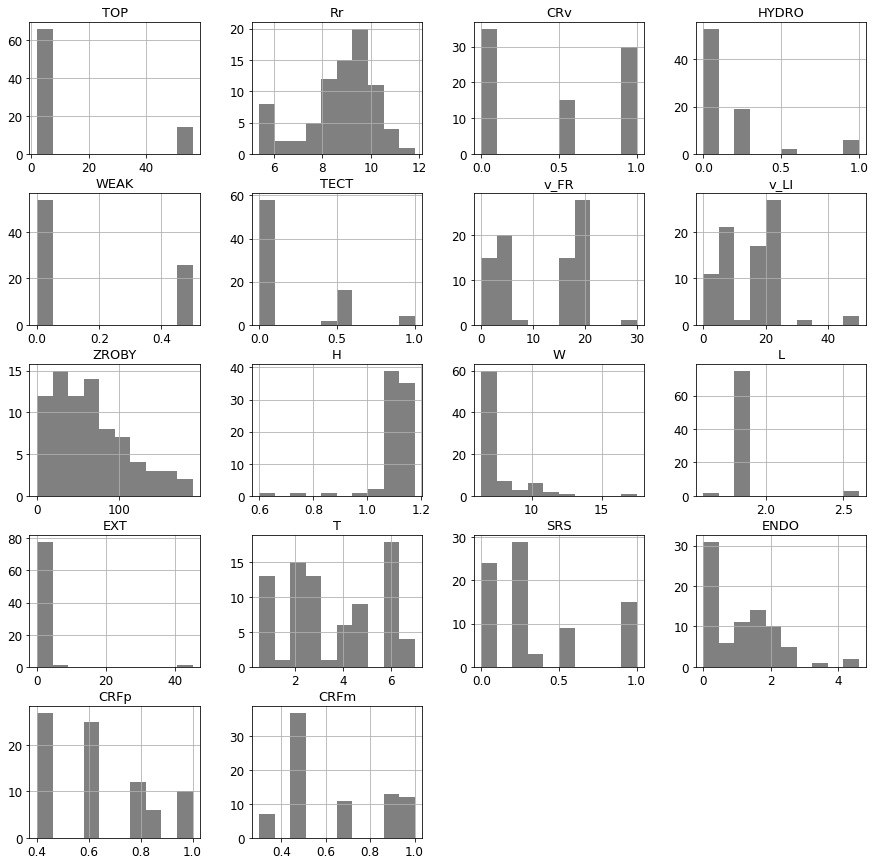

In [8]:
plt.rc('font', size=13)
plt.rc('axes', labelsize=14, titlesize=13)
plt.rc('legend', fontsize=13)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
data.hist(figsize=(15,15), color = 'grey')           #probably outliers in TOP and EXT

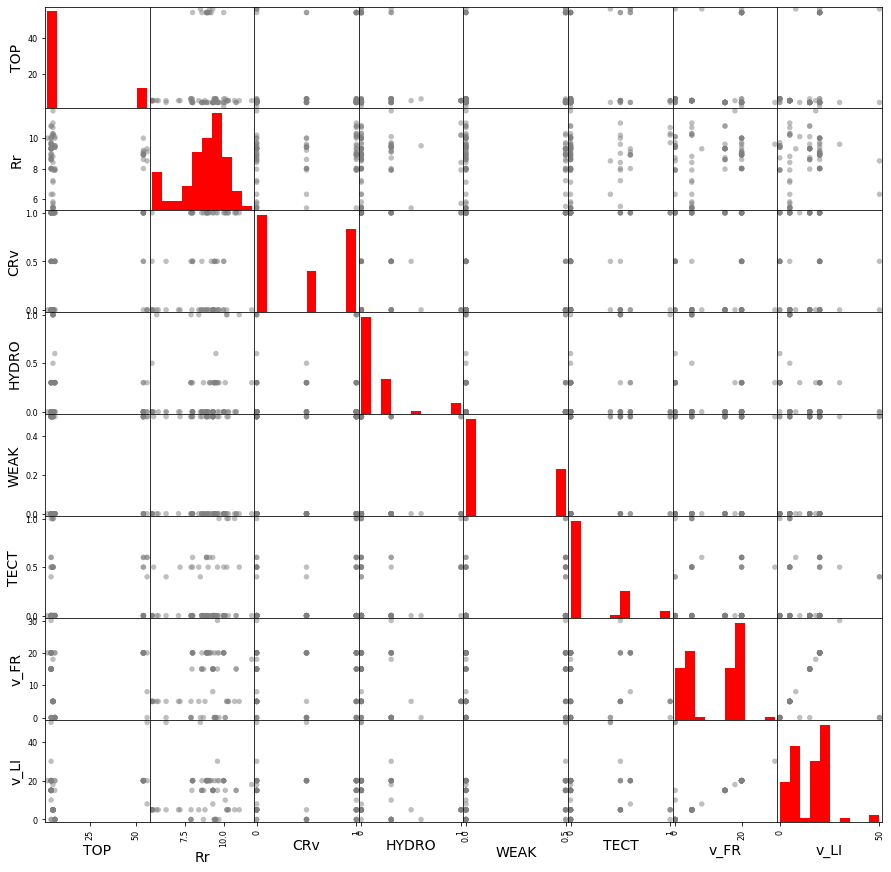

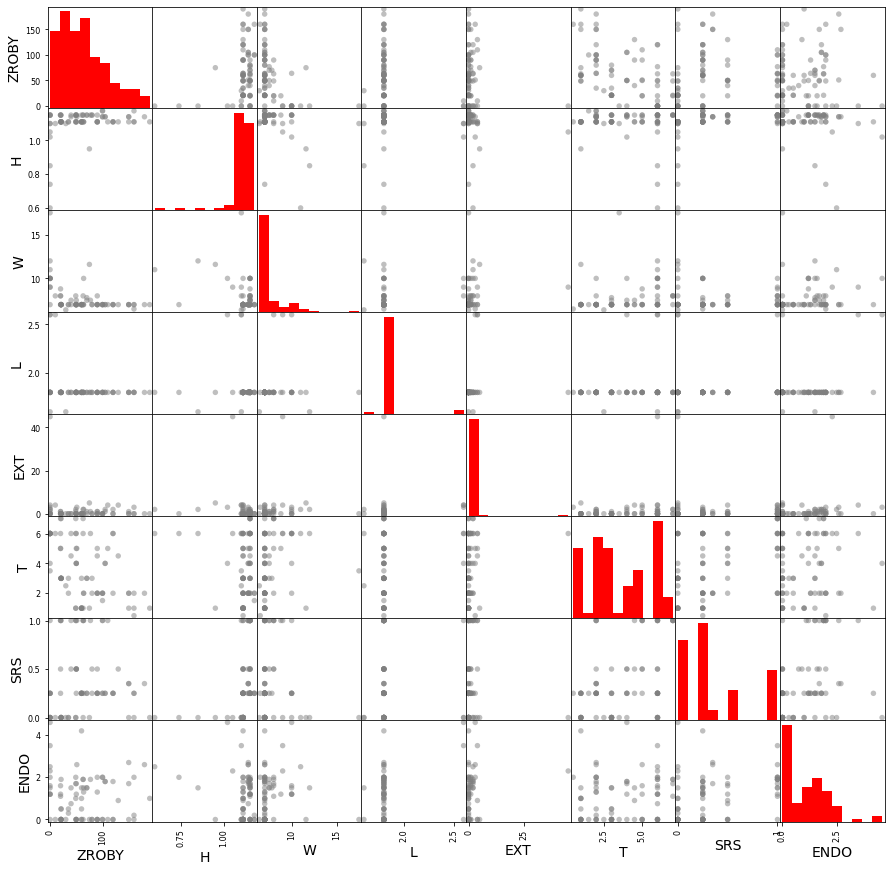

In [12]:
# re-searching for corr (dimensionality reduction in 2018, so there should be no correlation)
data_I = data.loc[:,'TOP':'v_LI'].copy()
data_II = data.loc[:,'ZROBY':'ENDO'].copy()
for plot in (data_I, data_II):
    pd.plotting.scatter_matrix(
        plot,
        figsize = (15,15),
        s = 120,
        color = 'grey',
        hist_kwds={'color':'red'}
    )

In [13]:
# v_li i v-fr - industry justification
data.corr()

,TOP,Rr,CRv,HYDRO,WEAK,TECT,v_FR,v_LI,ZROBY,H,W,L,EXT,T,SRS,ENDO,CRFp,CRFm
TOP,1.000000,0.065101,0.176822,-0.144882,0.306717,0.167803,0.321945,0.368972,-0.161702,0.101536,0.142527,-0.116407,0.268805,0.297507,0.274577,0.113966,0.303269,0.451044
Rr,0.065101,1.000000,0.229011,0.078842,-0.010106,0.150074,0.249651,0.121230,-0.116557,0.089743,0.197163,0.105932,-0.004082,0.058627,-0.083524,0.035178,0.206503,0.073634
CRv,0.176822,0.229011,1.000000,0.039717,0.018549,0.150310,-0.014329,-0.036519,-0.015636,0.157618,-0.016625,0.260434,-0.084480,0.000744,0.317735,0.416522,0.406493,0.376110
HYDRO,-0.144882,0.078842,0.039717,1.000000,-0.091502,0.210166,-0.318841,-0.345364,-0.012870,0.034584,0.085260,0.011438,-0.047900,0.116287,0.184215,0.200951,0.108669,0.061891
WEAK,0.306717,-0.010106,0.018549,-0.091502,1.000000,0.307661,0.132619,0.273742,-0.267838,-0.255525,0.060188,-0.179487,0.178048,0.204091,0.073697,-0.020368,0.171769,0.286446
TECT,0.167803,0.150074,0.150310,0.210166,0.307661,1.000000,-0.076142,0.020294,0.011378,-0.330339,0.071916,-0.153141,0.162436,0.091989,0.113229,0.082113,0.395309,0.331370
v_FR,0.321945,0.249651,-0.014329,-0.318841,0.132619,-0.076142,1.000000,0.613861,-0.238218,0.256487,0.145357,-0.323031,-0.227327,0.098473,0.010717,-0.316309,-0.224114,-0.158103
v_LI,0.368972,0.121230,-0.036519,-0.345364,0.273742,0.020294,0.613861,1.000000,-0.405445,-0.222715,0.319528,-0.132562,0.389389,0.278276,-0.113626,-0.089705,0.106874,0.118059
ZROBY,-0.161702,-0.116557,-0.015636,-0.012870,-0.267838,0.011378,-0.238218,-0.405445,1.000000,0.273628,-0.419005,-0.206132,-0.140517,-0.484424,0.052275,-0.058445,-0.201701,-0.269333
H,0.101536,0.089743,0.157618,0.034584,-0.255525,-0.330339,0.256487,-0.222715,0.273628,1.000000,-0.343338,-0.030031,-0.137058,-0.137347,0.327883,-0.173922,-0.448945,-0.349693


In [14]:
# looking for correlation with labels - expected values
pd.DataFrame([
    data.corr()['CRFp'].sort_values(ascending=False),
    data.corr()['CRFm'],
    data.corr()['CRFp'].sort_values(ascending=False).argsort(),
    data.corr()['CRFm'].sort_values(ascending=False).argsort(),
    ]).round(2)

,CRFp,CRFm,ENDO,W,CRv,TECT,EXT,TOP,L,Rr,WEAK,T,HYDRO,v_LI,SRS,ZROBY,v_FR,H
CRFp,1.00,0.77,0.50,0.45,0.41,0.40,0.30,0.30,0.29,0.21,0.17,0.11,0.11,0.11,0.01,-0.20,-0.22,-0.45
CRFm,0.77,1.00,0.52,0.46,0.38,0.33,0.27,0.45,0.25,0.07,0.29,0.19,0.06,0.12,0.23,-0.27,-0.16,-0.35
CRFp,17.00,16.00,15.00,14.00,13.00,12.00,11.00,10.00,9.00,8.00,7.00,6.00,5.00,4.00,3.00,2.00,1.00,0.00
CRFm,16.00,17.00,15.00,14.00,12.00,11.00,9.00,13.00,8.00,4.00,10.00,6.00,3.00,5.00,7.00,1.00,2.00,0.00


In [16]:
# reverse order, endo and CRv highest - this is justified by the essence of the phenomenon (industrial justification)
data.corr()['CRFp'].sort_values(ascending=False).argsort().loc[
    ["TOP","Rr","CRv","HYDRO","WEAK","TECT","v_FR","v_LI","ZROBY","H","SRS","ENDO"]
    ].sort_values(ascending=False) 

ENDO     15
CRv      13
TECT     12
TOP      10
Rr        8
WEAK      7
HYDRO     5
v_LI      4
SRS       3
ZROBY     2
v_FR      1
H         0
Name: CRFp, dtype: int64

In [17]:
# extras - four parameters which should not affect the value of CRFp labels, however W and EXT are high values
{"TOP","Rr","CRv","HYDRO","WEAK","TECT","v_FR","v_LI","ZROBY","H",'W',"L","EXT","T","SRS","ENDO"} - {"TOP","Rr","CRv","HYDRO","WEAK","TECT","v_FR","v_LI","ZROBY","H","SRS","ENDO"}

{'EXT', 'L', 'T', 'W'}

In [18]:
data.corr()['CRFp'].sort_values(ascending=False).argsort().loc[
    ['EXT', 'L', 'T', 'W']
    ].sort_values(ascending=False) 

W      14
EXT    11
L       9
T       6
Name: CRFp, dtype: int64

There are relatively high features that were not included in the `CRFp` indicator at the expert assessment stage (marked as having no impact)

4. **Przygotować dane pod względem algorytmów maszynowego uczenia** 
* uporządkować cechy typy CATEGORY:
    - określić martwe parametry,
    - rodzaj skał (wg Rr i Rc, usunąć 1),
* standaryzacja
* podzielić zbiory
* martwe parametry <br>
1: brak przykładów w zbiorze dla 1, 3 i 7 <br>
4: za dużo o 0,5

In [3]:
# reduces max - min
data.TOP.replace({56:5, 54:5}, inplace = True)         # zamiana 56 i 54 na 5
data.EXT.replace({45:4}, inplace = True)         # zamiana 56 i 54 na 5 

In [4]:
CRFp = data[['CRFp']]
CRFm = data[['CRFm']]
data_p = data[["TOP","Rr","CRv","HYDRO","WEAK","TECT","v_FR","v_LI","ZROBY","H","SRS","ENDO"]]
#data_m = data[["TOP","Rr","CRv","HYDRO","WEAK","TECT","v_FR","v_LI","ZROBY","H",'W',"L","EXT","T","SRS","ENDO"]]

## Train test split

In [59]:
import numpy as np
from sklearn.model_selection import train_test_split

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    data_p, CRFp, test_size=0.10, random_state=42)
[x.shape for x in [X_train, X_test, y_train, y_test]]


[(72, 12), (8, 12), (72, 1), (8, 1)]

## Stratified Shuffle

In [61]:
from sklearn.model_selection import StratifiedShuffleSplit

In [62]:
set_strat_ = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

In [63]:
list_strat_X = []
list_strat_y = []
for train_index, test_index in set_strat_.split(data_p, CRFp):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_stra, X_test_stra = data_p.iloc[train_index], data_p.iloc[test_index]
    y_train_stra, y_test_stra = CRFp.iloc[train_index], CRFp.iloc[test_index]
    list_strat_X.append([X_train_stra, X_test_stra])
    list_strat_y.append([X_train_stra, X_test_stra])

TRAIN: [20 10 71 63 40 25 35 55 24 48 11 15 44 67 53 58 59 23 26  0 13  4 18  9
  8 52 41 57 21 38 28 12 64 75 49 74 70 65 54 32 72 43 22  6 37  5 17 19
 77 60 42  2 14 30 50 76 68 29 46 16 51 27 69  7] TEST: [61 78 73 33 34 79 62  3 66 47 39 45 56 31 36  1]
TRAIN: [30 19 66 68 20 59 41 58  4 13 64 10 17 15 47  6 74  9 25 42 65 79 11 14
  5 60  2 38 78 62 16 73 36  3 45 52 43 24 48 35  1 69 26 57 40 27 55 75
 29 71 46 18 28 33  8 34 50 63 53 70 54 72 44 12] TEST: [ 0 77 31 67 51 61 56 22 37 76 21 49 32 23  7 39]
TRAIN: [ 2 26 67 17  8 13 56 11 30 44  4 10 55 43 38 35 20 31 68 51 63 40 37 61
 46 36 57 23 12 14 45  7 33 53 79 70 69  5 72 16  9 32 29 27 65 74 78  1
 21 47 64 22 76 54 24 15 50 59 66 34 62 41 18  3] TEST: [60 19 42 49 48 25  0 28 52  6 39 77 71 73 75 58]


## StandardScaler

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
scaler = StandardScaler() # for activation function other than tanh
scaler_output = StandardScaler() #for output - It is not necessary (labels c (0,1) )

In [21]:
scaler.fit(data_p)
scaler_output.fit(CRFp)

StandardScaler()

In [67]:
# only splited data
X_train_SS = scaler.transform(X_train)
X_test_SS = scaler.transform(X_test)
y_train_SS = scaler_output.transform(y_train)
y_test_SS = scaler_output.transform(y_test)

In [68]:
# splited by StratifiedShuffleSplit
X_train_str = scaler.transform(X_train_stra)
X_test_str = scaler.transform(X_test_stra)
y_train_str = scaler_output.transform(y_train_stra)
y_test_str = scaler_output.transform(y_test_stra)

## MinMaxScaler 
`Appropriate due to the range -1:1 of the activation functions tanh` , just for comparison

In [19]:
from sklearn.preprocessing import MinMaxScaler

scalerMinMax = MinMaxScaler(feature_range=(-1, 1))              #for tanh activation function 
scalerMinMax.fit(data_p)

X_trainMM = scalerMinMax.transform(X_train)
X_testMM = scalerMinMax.transform(X_test)

scalerMinMax_output = MinMaxScaler(feature_range=(-1, 1))
scalerMinMax_output.fit(CRFp)

y_trainMM = scalerMinMax_output.transform(y_train)
y_testMM = scalerMinMax_output.transform(y_test)

### SUMMARY

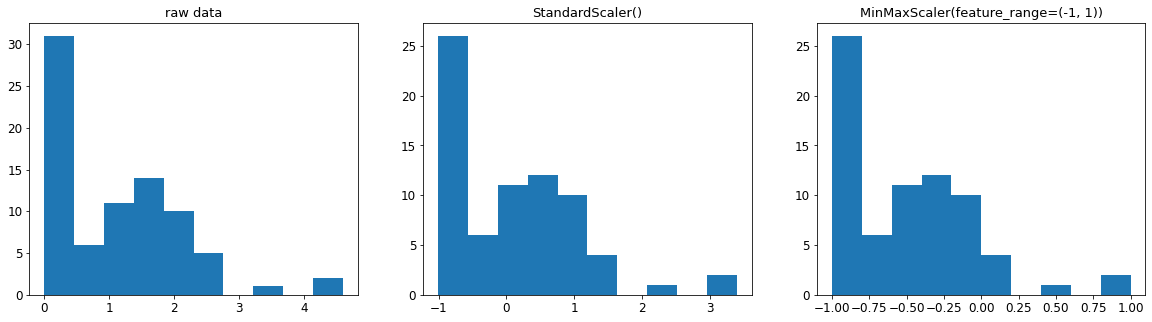

In [41]:
# for example histograms for ENDO - normalization looks good
example = 'ENDO'

plt.figure(figsize= (20,5))

plt.subplot(1, 3, 1)
plt.hist(data[[example]])
plt.gca().title.set_text("raw data")

plt.subplot(1, 3, 2)
plt.hist(pd.DataFrame(X_train_SS, columns = scaler.feature_names_in_)[[example]])
plt.gca().title.set_text(scaler)

plt.subplot(1, 3, 3)
plt.hist(pd.DataFrame(X_trainMM, columns = scalerMinMax.feature_names_in_)[[example]])
plt.gca().title.set_text(scalerMinMax)


# 5. Wybrać i wyuczyć model 
------------------------------------

In [26]:
tf.__version__

'2.9.1'

Performs a simple permutation involving the drawing of training examples and initial values of the weight vector. The `Checker_dist_box` class performs a simple test by repeating the learning 10 times and drawing a box plot.

In [21]:
X_train_ran = np.random.normal(loc=0.0, scale=1.0, size=(80,12))
y_train_ran = np.random.normal(loc=0.0, scale=1.0, size=(80,1))

c:\Users\Inspektor\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Inspektor\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Inspektor\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Inspektor\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Inspektor\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Inspektor\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does no

[0.252949436051386, 0.14852146303474226, 0.1999646749618279, 0.23693314928340728, 0.14492503788241667, 0.203004186113635, 0.292768798776551, 0.17961046862782803, 0.16696826055180639, 0.0846075564182502] średnia:  0.191 max:  0.293 struktura:  [6, 1]  !Coef Pearson


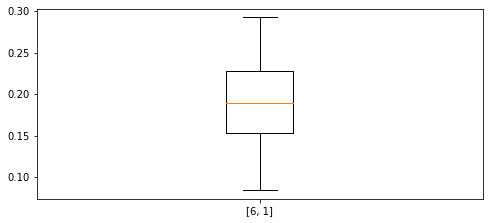

In [28]:
""" class Checker_dist_box implements ->
input_ = tf.keras.layers.Input(shape=(12,))
hidden1_ = tf.keras.layers.Dense(8, activation = 'tanh')(input_)
output = tf.keras.layers.Dense(1)(hidden1_)"""

random_model = Checker_dist_box(scalerMinMax,scalerMinMax_output,(X_train_ran,y_train_ran)) #MinMax due to tanh fn
random_model.compute(X_train_ran, y_train_ran, epochs = 70,
                    validation_split = 0.2, shuffle = True, neurons_ = 6, function_="tanh")
random_model.plot_box   #Coef Pearson for random input and output

`12 - 6 - 1`

R - mean 0.19; max 0.29 - relatively low box, little scatter of results. 

The `base_model` is the first and the simplest: tanh, MinMaxScaler and EarlyStopping

Restoring model weights from the end of the best epoch: 72.
Epoch 76: early stopping
Restoring model weights from the end of the best epoch: 137.
Epoch 141: early stopping
Restoring model weights from the end of the best epoch: 244.
Epoch 248: early stopping
Restoring model weights from the end of the best epoch: 35.
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 52.
Epoch 56: early stopping
Restoring model weights from the end of the best epoch: 15.
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 118.
Epoch 122: early stopping
Restoring model weights from the end of the best epoch: 23.
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 48.
Epoch 52: early stopping
Restoring model weights from the end of the best epoch: 13.
Epoch 17: early stopping
[-0.22587536640869105, 0.06756116125670526, 0.3790441593834015, 0.28986520215599176, 0.36281606073557104, -0.2961072597620802, 0.434514753501111

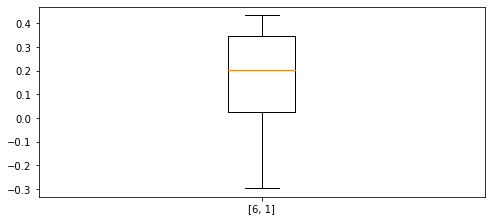

In [31]:
tf.keras.backend.clear_session()
callbacks=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

base_model = Checker_dist_box(scalerMinMax,scalerMinMax_output,(data_p, CRFp))
base_model.compute(X_train, y_train, epochs=300,
                    validation_split=0.2, shuffle=True, callbacks=[callbacks], neurons_=6, function_="tanh")
base_model.plot_box   

`12 - 6 - 1`

R - mean 0.14 (L); max 0.43 (H) - increase max result

The `model_001`: selu, StandardScaler and EarlyStopping. Class `Num1` inherits from `Checker_dist_box` - method `compute` adjusts to your logic (LeCun, Nadam etc.)

Restoring model weights from the end of the best epoch: 179.
Epoch 183: early stopping
Restoring model weights from the end of the best epoch: 93.
Epoch 97: early stopping
Restoring model weights from the end of the best epoch: 201.
Epoch 205: early stopping
Restoring model weights from the end of the best epoch: 109.
Epoch 113: early stopping
Restoring model weights from the end of the best epoch: 112.
Epoch 116: early stopping
[0.7714141227272413, 0.7691815410231246, 0.708634089716299, 0.78363775222676, 0.7695534588843007, 0.8333839480551526, 0.7849061543794001, 0.7679907148872395, 0.7728875068607377, 0.8185966200338999] średnia:  0.778 max:  0.833 struktura:  [6, 1]  !Coef Pearson


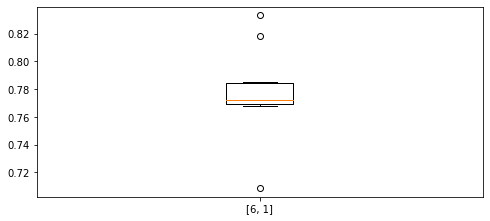

In [34]:
"""Inicjalizacja: LeCuna
Funkcja aktywacji: SELU
Normalizacja: -
Regularyzacja: 
Optymalizator: RMSProp; Nadam
Harmonogram uczenia:"""

model_001 = Num1(scaler, scaler_output, (data_p, CRFp))
model_001.compute(
    X_train_SS,
    y_train_SS, 
    epochs=300,
    validation_split=0.2,
    shuffle=True,
    callbacks=[callbacks],
    neurons_=6, 
    function_="selu"
    )
model_001.plot_box  

`12 - 6 - 1`

R - mean 0.78 (H); max 0.83 (H) - significant increase in quantity of R and mean. Very low box - **low dispersion of the results, high repeatability**

Models `002`, `003` and `004` increase their complexity

In [15]:
list_output = Hold_data() # writes model output to common list

In [24]:
tf.keras.backend.clear_session()
callbacks = tf.keras.callbacks.EarlyStopping(
    monitor ='val_loss',
    min_delta = 0,
    patience = 4,
    verbose = 1,
    mode = 'auto',
    baseline = None,
    restore_best_weights = True
)
#layers
model_002 = keras.models.Sequential()
model_002.add(keras.layers.Dense(7, activation='selu', input_shape=(12,), kernel_initializer=tf.keras.initializers.LecunNormal()))
model_002.add(keras.layers.Dense(1, kernel_initializer=tf.keras.initializers.LecunNormal()))

model_002.compile(
    loss = 'mean_squared_error',
    optimizer = 'Nadam',
    metrics = ["MSE"]
    )
#MinMaxScaler
history_002 = model_002.fit(
    X_train, 
    y_train, 
    epochs = 200,
    validation_split = 0.2,
    shuffle = True,
    callbacks = [callbacks]
    ) 
list_output.add_out(model_002, history_002)

#StandardScaler
history_012 = model_002.fit(        
    X_train_SS, 
    y_train_SS, 
    epochs = 400,
    validation_split = 0.2, 
    shuffle = True, 
    callbacks = [callbacks]
    ) 
list_output.add_out(model_002, history_012)

#StandardScaler + strated data
history_022 = model_002.fit(
    X_train_str,
    y_train_str,
    epochs = 400,
    validation_data = (X_test_str, y_test_str),
    shuffle = True,
    callbacks = [callbacks]
    )
list_output.add_out(model_002,history_022)

Epoch 1/200
2/2 [==============================] - 1s 149ms/step - loss: 2053.9707 - MSE: 2053.9707 - val_loss: 2253.4165 - val_MSE: 2253.4165
Epoch 2/200
2/2 [==============================] - 0s 20ms/step - loss: 2017.9756 - MSE: 2017.9756 - val_loss: 2218.9041 - val_MSE: 2218.9041
Epoch 3/200
2/2 [==============================] - 0s 28ms/step - loss: 1987.8414 - MSE: 1987.8414 - val_loss: 2185.0630 - val_MSE: 2185.0630
Epoch 4/200
2/2 [==============================] - 0s 23ms/step - loss: 1958.6202 - MSE: 1958.6202 - val_loss: 2151.0085 - val_MSE: 2151.0085
Epoch 5/200
2/2 [==============================] - 0s 36ms/step - loss: 1926.8273 - MSE: 1926.8273 - val_loss: 2114.6357 - val_MSE: 2114.6357
Epoch 6/200
2/2 [==============================] - 0s 36ms/step - loss: 1894.5055 - MSE: 1894.5055 - val_loss: 2077.4712 - val_MSE: 2077.4712
Epoch 7/200
2/2 [==============================] - 0s 23ms/step - loss: 1861.7007 - MSE: 1861.7007 - val_loss: 2040.0549 - val_MSE: 2040.0549
Epoch

In [25]:
list_output.print_() # 3 the best

    loss      ker_ini  act_fn    opt
0  6.269  LecunNormal  linear  Nadam
1  0.480  LecunNormal  linear  Nadam
2  0.459  LecunNormal  linear  Nadam


In [156]:
def plot_hist(history_, grid = True):
    """visualizes the data from the history.history file, 
    wizualizuje dane z pliku history.history
    
    Args:
        history_: `History` object 
        grid: matplotlib arg"""
    
    pd.DataFrame(getattr(history_, "history")).plot(figsize=(8, 5), style=["r--", "r-x", "g--", "g-*"])
    plt.grid(grid)
    plt.show()

def plot_sc_all(scaler_input, scaler_output, model_, data, out):
    """draws a scatter plot, computing the value of R, using the entire set (data, out) 
    after their transformation (scaler_input, scaler_output). Returns matplotlib plot.
    
    Args:
        scaler_input: scaler implementing the method transform  
        scaler_output: scaler implementing the method inverse_transform
        model_: tf treined model
        data: input data
        out: output data
        """
    y_pred_ = model_(scaler_input.transform(data))
    y_pred_ = np.ravel(scaler_output.inverse_transform(y_pred_))
    y_true_ = np.ravel(out)
    R = measures.pearsonr(y_pred_, y_true_)[0].round(2)
    print('Pearson correlation coefficient: {}'.format(R))
         
    pd.DataFrame.from_dict({
        "y_pred": y_pred_,
        "y_true": y_true_
    }).plot.scatter('y_true', "y_pred",c='r',ylim=(0, 1.2), xlim=(0, 1.2))
    plt.grid()
    plt.plot([0,1], [0,1], 'b--')
    plt.show()

Of the three models `002`, `012` and `022` made, the third achieved the best result. Before performing model tuning, I tested a few models that should be well suited to learning from the available data.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 104       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
2/2 [==============================] - 1s 115ms/step - loss: 2.0314 - MSE: 1.8677 - val_loss: 1.3459 - val_MSE: 1.1825
Epoch 2/500
2/2 [==============================] - 0s 19ms/step - loss: 1.9920 - MSE: 1.8286 - val_loss: 1.3376 - val_MSE: 1.1744
Epoch 3/500
2/2 [==============================] - 0s 24ms/step - loss: 1.9582 - MSE: 1.7951 - val_loss: 1.3289 - val_MSE: 1.1660
Epoch 4/500
2/2 [==============================] - 0s 24ms/step

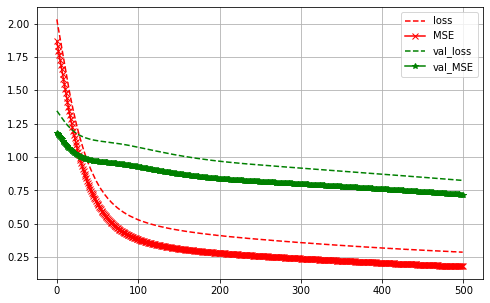

Pearson correlation coefficient: 0.85


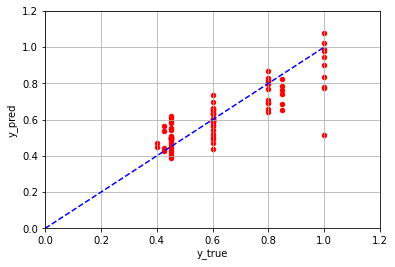

In [69]:
"""Inicjalizacja: He
Funkcja aktywacji: ELU
Normalizacja: brak w płytkiej
Regularyzacja: wczesne zatrzymanie; l2
Optymalizator: RMSPromp; Nadam
Harmonogram uczenia: 1 cykle
    
keras.layers.Dense(4, activation = "elu", kernel_nitializer="he_normal")"""

tf.keras.backend.clear_session()
try:
    del model_003
except:
    pass

model_003 = keras.models.Sequential()
model_003.add(keras.layers.Dense(8, activation='elu', input_shape=(12,), kernel_regularizer='l2', kernel_initializer="he_normal"))
model_003.add(keras.layers.Dense(1, kernel_regularizer='l2', kernel_initializer="he_normal"))
model_003.summary()
model_003.compile(
    loss = 'mean_squared_error',
    optimizer = 'Nadam',
    metrics = ["MSE"]
    )

#StandardScaler + strated data + elu
history_003 = model_003.fit(
    X_train_str,
    y_train_str,
    epochs = 500,
    validation_data = (X_test_str, y_test_str),
    shuffle = True,
    callbacks = [callbacks]
    )

list_output.add_out(model_003, history_003)

plot_hist(history_003)
plot_sc_all(scaler, scaler_output, model_003, data_p, CRFp)


Epoch 1/700


C:\Users\Inspektor\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 1s 329ms/step - loss: 1.0571 - MSE: 2.7466 - val_loss: 1.0584 - val_MSE: 2.2706
Epoch 2/700
2/2 [==============================] - 0s 20ms/step - loss: 1.0382 - MSE: 2.6740 - val_loss: 1.0399 - val_MSE: 2.1994
Epoch 3/700
2/2 [==============================] - 0s 22ms/step - loss: 1.0207 - MSE: 2.6121 - val_loss: 1.0218 - val_MSE: 2.1318
Epoch 4/700
2/2 [==============================] - 0s 24ms/step - loss: 1.0030 - MSE: 2.5464 - val_loss: 1.0038 - val_MSE: 2.0664
Epoch 5/700
2/2 [==============================] - 0s 26ms/step - loss: 0.9864 - MSE: 2.4885 - val_loss: 0.9859 - val_MSE: 2.0026
Epoch 6/700
2/2 [==============================] - 0s 28ms/step - loss: 0.9712 - MSE: 2.4344 - val_loss: 0.9681 - val_MSE: 1.9403
Epoch 7/700
2/2 [==============================] - 0s 27ms/step - loss: 0.9544 - MSE: 2.3773 - val_loss: 0.9510 - val_MSE: 1.8817
Epoch 8/700
2/2 [==============================] - 0s 104ms/step - loss: 0.9397 - MSE: 2.3227 - val_l

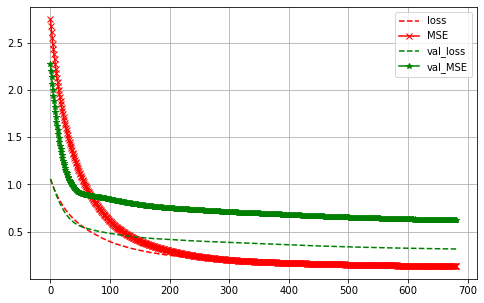

Pearson correlation coefficient: 0.88


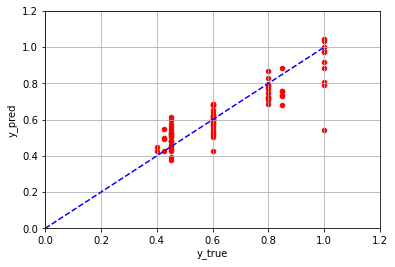

In [77]:
# HUBER elu ADAM

def huber_fn(y_true: list, y_pred: list) -> int:
    """Huber loss is a loss function, that is less sensitive to outliers in data than the squared error loss. Return Huber fn value.
    Args:
        y_true: labels
        y_pred: predicted
    """
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2 
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

tf.keras.backend.clear_session()
try:
    del model_004
except:
    pass

opt = tf.keras.optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999)

model_004 = keras.models.Sequential()
model_004.add(keras.layers.Dense(7, activation='elu', input_shape=(12,), kernel_regularizer='l2', kernel_initializer="he_normal"))
model_004.add(keras.layers.Dense(1, kernel_regularizer='l2', kernel_initializer="he_normal"))
model_004.compile(
    loss = huber_fn,
    optimizer = opt,
    metrics = ["MSE"]
    )

#StandardScaler + strated data + elu + hb
history_004 = model_004.fit(
    X_train_str, 
    y_train_str,
    epochs = 700,
    validation_data = (X_test_str, y_test_str),
    shuffle = True,
    callbacks = [callbacks]
    )

list_output.add_out(model_004, history_004)

plot_hist(history_004)
plot_sc_all(scaler, scaler_output, model_004, data_p, CRFp)


In [68]:
#model.layers

In [69]:
#weights, biases = model.get_weights()
#weights, biases

Using the Huber activation function increased the value of the metric from `0.85 to 0.89 (Pearson correlation coefficient)`

Three times repeated prediction made for four structures. Best result for `X` neurons (also upper limit of the test). This proves the necessity to re-test for a larger scope (10, 11 and 12 neuronos). Experience shows that it may have too many degrees of freedom.
Additionally, an increase in the number of neurons reduces the variance (*vide* - box plot). Which increases the repeatability of a better result. Learning curves don't look bad. 

The mean and the maximum value of MAE are similar for the `MAE` and `Huber_fn` functions, but in the second case, the learning curves are smoother

6. Dostroić model
------------------

In [81]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) /2 
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 4,
    verbose = 1,
    mode = 'auto',
    baseline = None,
    restore_best_weights = True
    )
#1
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=4, default=2)
    n_neurons = hp.Int("n_neurons", min_value=3, max_value=11)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["RMSprop", "Nadam", "Adam"])
    optimizer = {
        'RMSprop': tf.keras.optimizers.RMSprop(
            learning_rate = learning_rate,
            rho = 0.9,
            momentum = 0.0,
            epsilon = 1e-07,
            centered = False,
            name = 'RMSprop'
            ),
        'Nadam': tf.keras.optimizers.Nadam(
            learning_rate = learning_rate,
            beta_1 = 0.9,
            beta_2 = 0.999,
            epsilon = 1e-07,
            name = 'Nadam'
            ),
        "Adam": tf.keras.optimizers.Adam(
            lr = 0.001,
            beta_1 = 0.9, 
            beta_2 = 0.999
            )
    }.get(optimizer)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(
            n_neurons, 
            kernel_initializer = 'he_normal', 
            activation = "elu",
            kernel_regularizer = 'l2')
            )
    model.add(tf.keras.layers.Dense(
        1, 
        kernel_initializer = 'he_normal', 
        activation = "elu",
        kernel_regularizer = 'l2')
        )
    model.compile(loss=huber_fn, optimizer=optimizer, metrics=["MSE"])
    return model

In [116]:
random_search_tuner = kt.RandomSearch(build_model, objective="MSE", max_trials=50, overwrite=True,
                                    directory="proba_Kerac", project_name="my_SSN_keras", seed=42)

random_search_tuner.search(X_train_str, y_train_str, epochs=500,
                           validation_data=(X_test_stra, y_test_stra), callbacks=[callbacks])

top3_models = random_search_tuner.get_best_models(num_models=3)

best_model = top3_models[0]

random_search_tuner.get_best_hyperparameters(num_trials=3)
random_search_tuner.get_best_hyperparameters(num_trials=3)[0].values

Trial 50 Complete [00h 00m 00s]
MSE: 1.4794673919677734

Best MSE So Far: 0.10967396199703217
Total elapsed time: 00h 11m 26s
INFO:tensorflow:Oracle triggered exit


C:\Users\Inspektor\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


{'n_hidden': 3,
 'n_neurons': 10,
 'learning_rate': 0.0003647863570162414,
 'optimizer': 'Adam'}

In [117]:
[x.values for x in random_search_tuner.get_best_hyperparameters(num_trials=3)]

[{'n_hidden': 3,
  'n_neurons': 10,
  'learning_rate': 0.0003647863570162414,
  'optimizer': 'Adam'},
 {'n_hidden': 3,
  'n_neurons': 8,
  'learning_rate': 0.001989751755243559,
  'optimizer': 'Adam'},
 {'n_hidden': 3,
  'n_neurons': 9,
  'learning_rate': 0.0005070370705614628,
  'optimizer': 'Nadam'}]

C:\Users\Inspektor\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Pearson correlation coefficient: 0.88


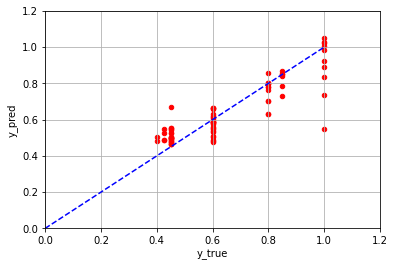

In [151]:
best_model_keras = plot_sc_all(
    scaler,
    scaler_output,
    random_search_tuner.get_best_models(num_models=3)[0],
    data_p,
    CRFp)

In [142]:
random_search_tuner.get_best_models(num_models=3)[0]

7. Zaprezentować rozwiązanie **(...)** 
------------------

# assert `MSE_new > MSE_old`
`MSE_old`

In [166]:
#old MSE for validation data only
old_output = pd.DataFrame(
    {'old MSE' :[0.028,0.014,0.018,0.0077,0.013,0.0086],
    'old R': [0.86,0.87,0.85,0.88,0.90,0.85]}, 
    index=["12-19-1", '12-16-1','12-13-1','12-10-1','12-7-1','12-4-1']
)
old_output

,old MSE,old R
12-19-1,0.0280,0.86
12-16-1,0.0140,0.87
12-13-1,0.0180,0.85
12-10-1,0.0077,0.88
12-7-1,0.0130,0.90
12-4-1,0.0086,0.85


In [168]:
target_ = data.CRFp.tolist() # data from from field research

In [169]:
# output from from old net - Matlab 2018
output_old = [0.80977, 0.93382, 0.92905, 0.91151, 0.92878, 0.93174, 0.93537,
0.97727, 0.9391 , 0.92472, 0.63107, 0.63377, 0.69431, 0.63008,
0.53391, 0.50832, 0.66687, 0.80758, 0.54027, 0.54112, 0.74659,
0.54157, 0.53765, 0.5331 , 0.59821, 0.81597, 0.81597, 0.68348,
0.8483 , 0.8136 , 0.54067, 0.53769, 0.8972 , 0.79948, 0.56671,
0.53319, 0.83307, 0.87477, 0.53669, 0.56079, 0.77923, 0.56878,
0.66505, 0.68106, 0.59562, 0.59636, 0.53669, 0.70215, 0.68469,
0.77413, 0.79795, 0.82999, 0.61131, 0.56482, 0.546  , 0.53844,
0.50207, 0.55816, 0.90946, 0.75523, 0.53619, 0.84741, 0.73992,
0.78393, 0.81649, 0.91975, 0.78775, 0.53991, 0.55218, 0.58523,
0.58523, 0.55251, 0.5587 , 0.56734, 0.58523, 0.54263, 0.54233,
0.57033, 0.57233, 0.57475]

In [179]:
def tf_eval(target_, output:list):
    "output:list evaluate data new neural net for target_ data"

    mse = tf.keras.losses.MeanSquaredError()
    h = tf.keras.losses.Huber()
    print(f'mse {mse(target_,output).numpy():.3}')
    print(f'huber {h(target_,output).numpy():.2}')

In [176]:
def alfa_pipeline(scaler_input, scaler_output, model_, data_):
    """pipeline - version alfa
    
    Args:
        scaler_input: scaler implementing the method transform  
        scaler_output: scaler implementing the method inverse_transform
        model_: tf trained model
        data: input data
        """
    y_pred_ = model_(scaler_input.transform(data_))
    y_pred_ = np.ravel(scaler_output.inverse_transform(y_pred_))
    return y_pred_

In [177]:
alfa_pipeline(scaler, scaler_output, model_004, data_p)

array([0.54324808, 0.97494357, 0.88776899, 1.03471063, 0.99891892,
       0.97697607, 0.78918289, 0.91743286, 1.04422937, 0.80963102,
       0.62524892, 0.61281779, 0.59848716, 0.65373261, 0.42728178,
       0.44549595, 0.5955988 , 0.72535976, 0.50110696, 0.45550146,
       0.74694396, 0.43446319, 0.52303423, 0.52004929, 0.68221653,
       0.71715946, 0.71715946, 0.54619303, 0.76075385, 0.68642793,
       0.51371113, 0.3766311 , 0.73813032, 0.51239698, 0.56769428,
       0.39294736, 0.73321473, 0.68813373, 0.61683237, 0.61986224,
       0.68113082, 0.60565669, 0.6095688 , 0.68095228, 0.63563688,
       0.52756001, 0.54039748, 0.61914075, 0.68569798, 0.70986522,
       0.79361575, 0.77051575, 0.49081088, 0.42638466, 0.44869319,
       0.42907115, 0.54582671, 0.461885  , 0.59620819, 0.58172648,
       0.42803441, 0.78278933, 0.79632215, 0.88294455, 0.76073628,
       0.86723046, 0.8282866 , 0.50673457, 0.55702295, 0.48439972,
       0.48439972, 0.50413465, 0.57012778, 0.59376027, 0.48439

In [182]:
# old net
tf_eval(
    target_, output_old
    ) 
# new model
tf_eval(
    target_, 
    alfa_pipeline(scaler, scaler_output, model_004, data_p)
    ) 

mse 0.0125
huber 0.0063
mse 0.00854
huber 0.0043


In [199]:
print("The best result for structure {} was R = {}".format(old_output.index[old_output['old R'].argmax()], old_output['old R'].max()))
print("The best result for new model was MSE = {:.02} , R = {}".format(
    tf.keras.losses.MeanSquaredError()(CRFp, alfa_pipeline(scaler, scaler_output, model_004, data_p)).numpy(),
    0.89
))

The best result for structure 12-7-1 was R = 0.9
The best result for new model was MSE = 0.062 , R = 0.89


In [184]:
def tf_eval_pearson(target_, output:list):
    "returns the Pearson correlation coefficient for the given arguments"

    target_ = tf.convert_to_tensor(target_)
    output = tf.convert_to_tensor(output)
    target_ = tf.reshape(target_,(-1,1))
    output = tf.reshape(output,(-1,1))
    return tfp.stats.correlation(target_,output).numpy()[0,0].round(2)

tf_eval_pearson(target_, output_old)

NameError: name 'tfp' is not defined

In [ ]:
# another way to add the learning result to the common list - using the function decorator
def add_to_list(common_list):
    def wrapper(fn_tf):
        obj_ = fn_tf()
        common_list.add_out(obj_.model, obj_)
    return wrapper

# to use is needed additional function 
@add_to_list(list_output)
def foo():
    history_00x = model_00x.fit(
        [...]
        )
    return history_002

list_output.out()

------------------
7. Zaprezentować rozwiązanie (vide - ocena modelu)
8. Przygotowć potok. Podzielić na katologi produkcyjne. Pokryć sieć testami jednostkowymi. 
------------------


In [203]:
# temporary solution
def alfa_pipeline(scaler_input, scaler_output, model_, data_):
    """pipeline - version alfa
    
    Args:
        scaler_input: scaler implementing the method transform  
        scaler_output: scaler implementing the method inverse_transform
        model_: tf trained model
        data: input data
        """
    y_pred_ = model_(scaler_input.transform(data_))
    y_pred_ = np.ravel(scaler_output.inverse_transform(y_pred_))
    return y_pred_

In [204]:
alfa_pipeline(scaler, scaler_output, model_004, data_p)

array([0.54324808, 0.97494357, 0.88776899, 1.03471063, 0.99891892,
       0.97697607, 0.78918289, 0.91743286, 1.04422937, 0.80963102,
       0.62524892, 0.61281779, 0.59848716, 0.65373261, 0.42728178,
       0.44549595, 0.5955988 , 0.72535976, 0.50110696, 0.45550146,
       0.74694396, 0.43446319, 0.52303423, 0.52004929, 0.68221653,
       0.71715946, 0.71715946, 0.54619303, 0.76075385, 0.68642793,
       0.51371113, 0.3766311 , 0.73813032, 0.51239698, 0.56769428,
       0.39294736, 0.73321473, 0.68813373, 0.61683237, 0.61986224,
       0.68113082, 0.60565669, 0.6095688 , 0.68095228, 0.63563688,
       0.52756001, 0.54039748, 0.61914075, 0.68569798, 0.70986522,
       0.79361575, 0.77051575, 0.49081088, 0.42638466, 0.44869319,
       0.42907115, 0.54582671, 0.461885  , 0.59620819, 0.58172648,
       0.42803441, 0.78278933, 0.79632215, 0.88294455, 0.76073628,
       0.86723046, 0.8282866 , 0.50673457, 0.55702295, 0.48439972,
       0.48439972, 0.50413465, 0.57012778, 0.59376027, 0.48439

Attempts to implement various variants generated errors in calculations, the error consists in omitting the `in_scaler_tf class`. This error also occurred when implementing the `tf.keras.layers.Normalization class`. 

In [112]:
# only a sketch
class in_scaler_tf(tf.keras.layers.Layer):
    def __init__(self, scaler = scalerMinMax):
        self.scaler = scaler
        super(in_scaler_tf,self).__init__()
        
    def call(self, INPUT):
        INPUT 
        [...]
        return INPUT

In [113]:
# only a sketch
class out_scaler_tf(tf.keras.layers.Layer):
    def __init__(self, scaler = scalerMinMax_output):
        self.scaler = scaler
        super(out_scaler_tf,self).__init__()
        
    def call(self, INPUT):
        INPUT 
        [...]
        return INPUT

In [17]:
norm = tf.keras.layers.Normalization(axis=-1, mean=None, variance=None)
norm.adapt(data_p)
norm.variance
norm.mean
data_p.describe()
pd.DataFrame(norm(data_p).numpy()).describe()
#pd.DataFrame(in_scaler_tf(mean, variance)(data_p).numpy()).describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,80.000000,8.000000e+01,8.000000e+01
mean,-1.356006e-07,3.725290e-07,-3.874302e-08,-4.321337e-08,-7.450581e-09,-6.258487e-08,7.227063e-08,4.656613e-08,-6.705523e-08,0.000001,-3.576279e-08,-7.450581e-08
std,1.006309e+00,1.006309e+00,1.006309e+00,1.006309e+00,1.006309e+00,1.006309e+00,1.006309e+00,1.006309e+00,1.006309e+00,1.006309,1.006309e+00,1.006309e+00
min,-3.562167e+00,-2.310985e+00,-1.042572e+00,-5.714286e-01,-6.938887e-01,-5.772645e-01,-1.406477e+00,-1.340448e+00,-1.308125e+00,-6.081404,-9.944057e-01,-1.005055e+00
25%,-9.356845e-01,-5.094524e-01,-1.042572e+00,-5.714286e-01,-6.938887e-01,-5.772645e-01,-7.956294e-01,-8.278487e-01,-8.706945e-01,0.015692,-9.944057e-01,-1.005055e+00
50%,3.775567e-01,1.834449e-01,6.950480e-02,-5.714286e-01,-6.938887e-01,-5.772645e-01,4.260665e-01,1.973509e-01,-5.832409e-02,0.015692,-2.790059e-01,-1.791641e-03
75%,3.775567e-01,5.991836e-01,1.181582e+00,5.000000e-01,1.441153e+00,8.874365e-01,1.036914e+00,7.099507e-01,5.665762e-01,0.493896,4.363939e-01,7.148247e-01
max,1.690798e+00,2.123558e+00,1.181582e+00,3.000000e+00,1.441153e+00,2.869091e+00,2.258610e+00,3.785549e+00,2.649577e+00,0.792773,1.867194e+00,3.390193e+00


In [18]:
pd.DataFrame(in_scaler_tf(mean, variance)(data_p).numpy()).describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,80.000000,8.000000e+01,8.000000e+01
mean,-1.356006e-07,3.725290e-07,-3.874302e-08,-4.321337e-08,-7.450581e-09,-6.258487e-08,7.227063e-08,4.656613e-08,-6.705523e-08,0.000001,-3.576279e-08,-7.450581e-08
std,1.006309e+00,1.006309e+00,1.006309e+00,1.006309e+00,1.006309e+00,1.006309e+00,1.006309e+00,1.006309e+00,1.006309e+00,1.006309,1.006309e+00,1.006309e+00
min,-3.562167e+00,-2.310985e+00,-1.042572e+00,-5.714286e-01,-6.938887e-01,-5.772645e-01,-1.406477e+00,-1.340448e+00,-1.308125e+00,-6.081404,-9.944057e-01,-1.005055e+00
25%,-9.356845e-01,-5.094524e-01,-1.042572e+00,-5.714286e-01,-6.938887e-01,-5.772645e-01,-7.956294e-01,-8.278487e-01,-8.706945e-01,0.015692,-9.944057e-01,-1.005055e+00
50%,3.775567e-01,1.834449e-01,6.950480e-02,-5.714286e-01,-6.938887e-01,-5.772645e-01,4.260665e-01,1.973509e-01,-5.832409e-02,0.015692,-2.790059e-01,-1.791641e-03
75%,3.775567e-01,5.991836e-01,1.181582e+00,5.000000e-01,1.441153e+00,8.874365e-01,1.036914e+00,7.099507e-01,5.665762e-01,0.493896,4.363939e-01,7.148247e-01
max,1.690798e+00,2.123558e+00,1.181582e+00,3.000000e+00,1.441153e+00,2.869091e+00,2.258610e+00,3.785549e+00,2.649577e+00,0.792773,1.867194e+00,3.390193e+00


In [15]:
mean = [[4.7125    ,  8.7352495 ,  0.46875   ,  0.16000001,  0.16250001,
         0.1675    , 11.5125    , 13.075     , 62.800003  ,  1.1086874 ,
         0.3475    ,  1.0518751 ]]

variance = [[5.7984376e-01, 2.0828702e+00, 2.0214844e-01, 7.8400001e-02,
        5.4843750e-02, 8.4193759e-02, 6.6999840e+01, 9.5144371e+01,
        2.3047351e+03, 6.9967150e-03, 1.2211875e-01, 1.0953401e+00]]
"""        
mean = [[13.3625    ,  8.7352495 ,  0.46875   ,  0.16000001,  0.16250001,
         0.1675    , 11.5125    , 13.075     , 62.800003  ,  1.1086874 ,
         0.3475    ,  1.0518751 ]]

variance = [[3.5840610e+02, 2.0828702e+00, 2.0214844e-01, 7.8400001e-02,
        5.4843750e-02, 8.4193759e-02, 6.6999840e+01, 9.5144371e+01,
        2.3047351e+03, 6.9967150e-03, 1.2211875e-01, 1.0953401e+00]]"""

class in_scaler_tf(tf.keras.layers.Layer):
    """from standard scaler, requires mean and variance"""
    def __init__(self, mean, variance):
        super(in_scaler_tf,self).__init__()
        self.mean = mean
        self.variance = variance

    def call(self, input):
        input = tf.cast(input, tf.float32)
        return ((input - self.mean) /
                tf.maximum(tf.sqrt(self.variance), tf.keras.backend.epsilon()))

In [48]:
#for output

class out_scaler_tf(tf.keras.layers.Layer):
    """from standard scaler, requires mean and variance"""
    def __init__(self, mean, variance):
        super().__init__()
        self.mean = tf.cast(mean, tf.float32)
        self.variance = tf.cast(variance, tf.float32)

    def call(self, input):
        input = tf.cast(input, tf.float32)
        return  (input * tf.maximum(tf.sqrt(self.variance), tf.keras.backend.epsilon())) + self.mean

In [54]:
pd.DataFrame(scaler_output.inverse_transform(CRFp)).describe()

,0
count,80.000000
mean,0.769886
std,0.037277
min,0.722612
25%,0.732235
50%,0.761105
75%,0.799598
max,0.838092


In [49]:
pd.DataFrame(out_scaler_tf(scaler_output.mean_[0], scaler_output.var_[0])(CRFp).numpy()).describe()

,0
count,80.000000
mean,0.769886
std,0.037277
min,0.722612
25%,0.732235
50%,0.761105
75%,0.799598
max,0.838091


In [ ]:
norm2 = in_scaler_tf()

In [115]:
tf.random.set_seed(
    42
)
model = tf.keras.models.Sequential()
model.add(norm2)
model.add(tf.keras.layers.Dense(7, activation = 'relu', input_shape = (12,), kernel_initializer = 'he_normal'))
model.add(tf.keras.layers.Dense(4, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(tf.keras.layers.Dense(1))
model.compile(loss = 'mean_squared_error',
             optimizer = 'SGD',
             metrics = ["MSE"])

Epoch 1/100
2/2 [==============================] - 1s 178ms/step - loss: 0.1188 - MAE: 0.2937 - val_loss: 0.0971 - val_MAE: 0.2440
Epoch 2/100
2/2 [==============================] - 0s 23ms/step - loss: 0.1110 - MAE: 0.2800 - val_loss: 0.0910 - val_MAE: 0.2310
Epoch 3/100
2/2 [==============================] - 0s 33ms/step - loss: 0.1042 - MAE: 0.2681 - val_loss: 0.0856 - val_MAE: 0.2190
Epoch 4/100
2/2 [==============================] - 0s 34ms/step - loss: 0.0981 - MAE: 0.2574 - val_loss: 0.0808 - val_MAE: 0.2074
Epoch 5/100
2/2 [==============================] - 0s 22ms/step - loss: 0.0926 - MAE: 0.2465 - val_loss: 0.0766 - val_MAE: 0.1972
Epoch 6/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0878 - MAE: 0.2373 - val_loss: 0.0728 - val_MAE: 0.1886
Epoch 7/100
2/2 [==============================] - 0s 30ms/step - loss: 0.0835 - MAE: 0.2283 - val_loss: 0.0696 - val_MAE: 0.1807
Epoch 8/100
2/2 [==============================] - 0s 27ms/step - loss: 0.0797 - MAE: 0.2

In [ ]:
model.predict(date_p)

9. **Uruchomić**, monitorować i utrzymać system./
------------------

**after implementing the input scaler and output scaler in the model - after creating a pipeline and executing save_model**

In [ ]:
"""
import joblib

new_model = tf.keras.models.load_model('ANNmodel')
out_ = joblib.load('scaler2.pkl')
in_ = joblib.load('scalerMinMax.pkl')

data = pd.read_excel("SNN.xls",header = None, sheet_name= 1)
"""

'\nimport joblib\n\nnew_model = tf.keras.models.load_model(\'ANNmodel\')\nout_ = joblib.load(\'scaler2.pkl\')\nin_ = joblib.load(\'scalerMinMax.pkl\')\n\ndate = pd.read_excel("SNN.xls",header = None, sheet_name= 1)\n'

In [ ]:
# DOCKER 
# docker run -it --rm -v "C:\\Users\\Inspektor\\ANNmodel:/models/siecNN/1" -p 8500:8500 -p 8501:8501 -e MODEL_NAME=siecNN tensorflow/serving

In [ ]:
#SSN_CRFp(data_p[:10], in_, out_,new_model)  # 10 dodatkowych danych testowych

#in_.transform(data_p[:10])

# new_model.predict( ... )
# out_.inverse_transform( ...)

In [4]:
import json

def _to_pred(to_pred, in_):
    request_json = json.dumps({
        "signature_name": "serving_default",
        "instances": in_.transform(to_pred.tolist()),
    })
    return request_json

request_json = _to_pred([[1,2,3,4,5,6,7,8,6,5,4]], in_)

In [ ]:
#siec NN
import requests

server_url = "http://localhost:8501/v1/models/siecNN:predict"
response = requests.post(server_url, data=request_json)
response.raise_for_status()  # raise an exception in case of error
response = response.json()

In [ ]:
# output scaler
out_.inverse_transform(
    response['predictions']
)


# THE END

extras

In [ ]:
np.save("ha.npy", X_train.to_numpy()[0:3].reshape(-1,12,1))

In [ ]:
# bez normalizacji
!saved_model_cli run --dir ANNmodel --tag_set serve --signature_def serving_default --inputs {'flatten_input'}=ha.npy

Result for output key dense_1:
[[0.76234436]
 [0.78554124]
 [0.78554124]]


2022-06-10 22:10:39.358681: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-06-10 22:10:39.358735: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-10 22:10:52.723844: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2022-06-10 22:10:52.723898: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-10 22:10:52.732035: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: DESKTOP-RR620JF
2022-06-10 22:10:52.732241: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: DESKTOP-RR620JF
2022-06-10 22:10:52.733264: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is

# ZAMIENIA NAZWY KOLUMN

In [ ]:
#odczytanie excela oraz konwersja z ',' na '.'
br_dane = pd.read_excel('SSN\ANN.xlsx', sheet_name = 'tabela', engine = 'openpyxl', thousands=".")

In [ ]:
br_dane.columns

Index(['Rodzaj skał stropowych', 'Wytrzymałość na rozciąganie',
       'Spękania pionowe', 'Zawodnienie', 'Płaszczyzny osłabienia',
       'Występowanie zaburzeń zalegania złoża ',
       'Średni postęp miesięczny frontu', 'Średni postęp mieś. likwidacji',
       'Występowanie zaszłości (stare wyrobiska, zroby)',
       'Głębokość zalegania złoża', 'Rzeczywista szerokość', 'Długość kotwi',
       'Dodatkowa obudowa', 'Czas istnienia wyrobiska',
       'Opadnięcia elementów SRS',
       'Rozwarstwienia stwierdzone badaniem endoskopowym', 'Predyspozycja',
       'Możliwość utrzymania'],
      dtype='object')

In [ ]:
{a:a.upper() for a in br_dane.columns}

{'Rodzaj skał stropowych': 'RODZAJ SKAŁ STROPOWYCH',
 'Wytrzymałość na rozciąganie': 'WYTRZYMAŁOŚĆ NA ROZCIĄGANIE',
 'Spękania pionowe': 'SPĘKANIA PIONOWE',
 'Zawodnienie': 'ZAWODNIENIE',
 'Płaszczyzny osłabienia': 'PŁASZCZYZNY OSŁABIENIA',
 'Występowanie zaburzeń zalegania złoża ': 'WYSTĘPOWANIE ZABURZEŃ ZALEGANIA ZŁOŻA ',
 'Średni postęp miesięczny frontu': 'ŚREDNI POSTĘP MIESIĘCZNY FRONTU',
 'Średni postęp mieś. likwidacji': 'ŚREDNI POSTĘP MIEŚ. LIKWIDACJI',
 'Występowanie zaszłości (stare wyrobiska, zroby)': 'WYSTĘPOWANIE ZASZŁOŚCI (STARE WYROBISKA, ZROBY)',
 'Głębokość zalegania złoża': 'GŁĘBOKOŚĆ ZALEGANIA ZŁOŻA',
 'Rzeczywista szerokość': 'RZECZYWISTA SZEROKOŚĆ',
 'Długość kotwi': 'DŁUGOŚĆ KOTWI',
 'Dodatkowa obudowa': 'DODATKOWA OBUDOWA',
 'Czas istnienia wyrobiska': 'CZAS ISTNIENIA WYROBISKA',
 'Opadnięcia elementów SRS': 'OPADNIĘCIA ELEMENTÓW SRS',
 'Rozwarstwienia stwierdzone badaniem endoskopowym': 'ROZWARSTWIENIA STWIERDZONE BADANIEM ENDOSKOPOWYM',
 'Predyspozycja': 'PREDY

In [ ]:
new_name = {'Rodzaj skał stropowych': 'TOP',
 'Wytrzymałość na rozciąganie': 'Rr',
 'Spękania pionowe': 'CRv',
 'Zawodnienie': 'HYDRO',
 'Płaszczyzny osłabienia': 'WEAK',
 'Występowanie zaburzeń zalegania złoża ': 'TECT',
 'Średni postęp miesięczny frontu': 'v_FR',
 'Średni postęp mieś. likwidacji': 'v_LI',
 'Występowanie zaszłości (stare wyrobiska, zroby)': 'ZROBY',
 'Głębokość zalegania złoża': 'H',
 'Rzeczywista szerokość': 'W',
 'Długość kotwi': 'L',
 'Dodatkowa obudowa': 'EXT',
 'Czas istnienia wyrobiska': 'T',
 'Opadnięcia elementów SRS': 'SRS',
 'Rozwarstwienia stwierdzone badaniem endoskopowym': 'ENDO',
 'Predyspozycja': 'CRFp',
 'Możliwość utrzymania': 'CRFm'}
new_name.values()

dict_values(['TOP', 'Rr', 'CRv', 'HYDRO', 'WEAK', 'TECT', 'v_FR', 'v_LI', 'ZROBY', 'H', 'W', 'L', 'EXT', 'T', 'SRS', 'ENDO', 'CRFp', 'CRFm'])

In [ ]:
# nowe nazwy
br_dane.columns = new_name.values()

In [ ]:
br_dane.head()

,TOP,Rr,CRv,HYDRO,WEAK,TECT,v_FR,v_LI,ZROBY,H,W,L,EXT,T,SRS,ENDO,CRFp,CRFm
0,5,11.8,0.0,0.3,0.0,0.0,18,18,0,1.10,17.5,1.8,0,3.5,0.0,0.0,1.0,1.0
1,4,9.6,0.0,0.3,0.5,0.5,30,30,0,0.85,12.0,1.6,2,6.0,0.0,1.5,1.0,1.0
2,56,9.3,0.0,0.0,0.0,0.6,8,8,75,0.95,11.6,1.8,5,1.0,0.0,0.0,1.0,1.0
3,4,8.7,1.0,0.3,0.0,0.0,0,0,0,1.02,10.0,2.6,3,4.0,0.0,4.6,1.0,1.0
4,4,9.7,0.0,0.0,0.5,1.0,0,0,0,0.74,7.0,1.8,0,6.0,0.0,2.0,1.0,1.0


In [ ]:
br_dane.to_csv('SSN\out1.csv', index = False)

In [ ]:
br_dane.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TOP     80 non-null     int64  
 1   Rr      80 non-null     float64
 2   CRv     80 non-null     float64
 3   HYDRO   80 non-null     float64
 4   WEAK    80 non-null     float64
 5   TECT    80 non-null     float64
 6   v_FR    80 non-null     int64  
 7   v_LI    80 non-null     int64  
 8   ZROBY   80 non-null     int64  
 9   H       80 non-null     float64
 10  W       80 non-null     float64
 11  L       80 non-null     float64
 12  EXT     80 non-null     int64  
 13  T       80 non-null     float64
 14  SRS     80 non-null     float64
 15  ENDO    80 non-null     float64
 16  CRFp    80 non-null     float64
 17  CRFm    80 non-null     float64
dtypes: float64(13), int64(5)
memory usage: 11.4 KB


GOTOWE - NAZWY KOLUMN ZAMIENIONE

# OKREŚLIĆ MARTWE WARTOŚCI (NIE UŻYTE)
1: 1,3,7 <br>
4: za dużo o 0,5

In [ ]:
[br_dane[a].unique() for a in br_dane]

[array([ 5,  4, 56,  6, 54,  2], dtype=int64),
 array([11.8 ,  9.6 ,  9.3 ,  8.7 ,  9.7 ,  8.5 , 10.1 ,  6.3 ,  9.1 ,
         9.4 ,  7.9 ,  8.9 ,  5.4 ,  8.72,  7.96,  9.5 , 10.  ,  9.  ,
         8.  ,  9.2 ,  8.6 ,  5.7 ,  7.1 ,  5.8 ,  5.5 ,  8.8 , 10.2 ,
         8.4 , 11.  , 10.3 , 10.7 ,  7.2 ,  9.31,  8.59, 10.8 ]),
 array([0. , 1. , 0.5]),
 array([0.3, 0. , 0.5, 0.6, 1. ]),
 array([0. , 0.5]),
 array([0. , 0.5, 0.6, 1. , 0.4]),
 array([18, 30,  8,  0, 20,  5, 15], dtype=int64),
 array([18, 30,  8,  0, 50, 15, 10, 20,  5], dtype=int64),
 array([  0,  75,  10,  30, 180, 150,  40, 160, 100,  60, 190, 105,  51,
         50,  80,  20,  70,  90,  63,  49,  77,  21, 130, 120,  64, 110,
         35], dtype=int64),
 array([1.1  , 0.85 , 0.95 , 1.02 , 0.74 , 1.05 , 0.6  , 1.14 , 1.175,
        1.11 , 1.15 ]),
 array([17.5, 12. , 11.6, 10. ,  7. ,  9. ,  8. , 11. ,  6.4,  7.5,  8.8,
         7.8,  6.5]),
 array([1.8, 1.6, 2.6]),
 array([ 0,  2,  5,  3, 45,  4,  1], dtype=int64),
 array([

## Huber loss plot

Text(0.5, 1.0, 'Huber loss')

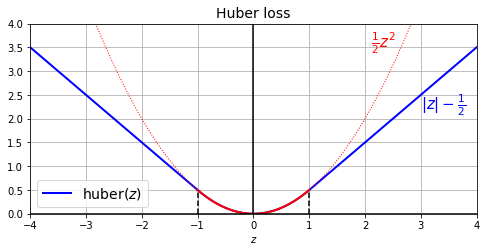

In [ ]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
z_center = np.linspace(-1, 1, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z ** 2 / 2, "r:", linewidth=1)
plt.plot(z_center, z_center ** 2 / 2, "r", linewidth=2)
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "k--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "k--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.text(2.1, 3.5, r"$\frac{1}{2}z^2$", color="r", fontsize=15)
plt.text(3.0, 2.2, r"$|z| - \frac{1}{2}$", color="b", fontsize=15)
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)

# Pre-prepared network aka `2018`

In [ ]:
import joblib

new_model = tf.keras.models.load_model('ANNmodel')
out_ = joblib.load('scaler2.pkl')
in_ = joblib.load('scalerMinMax.pkl')
data = pd.read_excel("SNN.xls",header = None, sheet_name= 1)

def SSN_CRFp(data, input_scaler, output_scaler, model, flatten = True):
    predict_ = output_scaler.inverse_transform(model.predict(input_scaler.transform(data))).round(5)
    if flatten:
        return predict_.flatten()
    else:
        return predict_   

SSN_CRFp(data_p, in_, out_,new_model)

NameError: name 'date_p' is not defined

In [ ]:
in_ = joblib.load('scalerMinMax.pkl')